In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import regionmask
import pandas as pd
from datetime import datetime, timedelta
import utils
from matplotlib.colors import SymLogNorm
import xesmf as xe
from matplotlib import pyplot as plt, animation
from IPython.display import HTML, display


In [2]:
ds_delta = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/SEA/OutputDir/GEOSChem.AerosolMass.20160*', combine = 'by_coords')

In [3]:
ds_base = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/GEOSChem.AerosolMass.20160*', combine = 'by_coords')

In [4]:
ds_emisbase = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_base/CEDS/OutputDir/HEMCO_diagnostics.20160*', combine = 'by_coords')

In [5]:
ds_emispulse = xr.open_mfdataset(f'../GCrundirs/IRF_runs/BC_sustained/SEA/OutputDir/HEMCO_diagnostics.20160*.nc', combine = 'by_coords')

ds_conc2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_EAS_BC/OutputDir/GEOSChem.AerosolMass.201601*.nc4', combine = 'by_coords')
ds_emis2x = xr.open_mfdataset('../GCrundirs/IRF_runs/BC_2x/2x_EAS_BC/OutputDir/HEMCO_diagnostics.201601*', combine = 'by_coords')

In [6]:
height = pd.read_excel('gc_altitude.xlsx')

In [7]:
height_ds = height.diff().dropna().to_xarray().rename({'index':'lev'})
height_ds['lev'] = ds_base['lev']
height_ds = height_ds.rename({'altitude':'dz'}) 
height_ds['dz']*=1e3


In [8]:
ds_emisbase = xr.merge([ds_emisbase, height_ds], join = 'inner')
ds_emispulse = xr.merge([ds_emispulse, height_ds], join = 'inner')
ds_base = xr.merge([ds_base, height_ds], join = 'inner')
ds_delta = xr.merge([ds_delta, height_ds], join = 'inner')
#ds_conc2x = xr.merge([ds_conc2x, height_ds], join = 'inner')
#ds_emis2x = xr.merge([ds_emis2x, height_ds], join = 'inner')

In [9]:
sec_day = 86400

In [10]:
for ds in [ds_emispulse, ds_emisbase]:
    utils.combine_BC(ds)

## Import China Coal Data

In [11]:
df = pd.read_excel('January 2021 Global Coal Plant Tracker.xlsx', sheet_name = 'Units')

In [12]:
df.columns

Index(['Tracker ID', 'TrackerLOC', 'ParentID', 'Wiki page', 'Country',
       'Subnational unit (province, state)', 'Unit', 'Plant', 'Chinese Name',
       'Other names', 'Sponsor', 'Parent', 'Capacity (MW)', 'Status', 'Year',
       'RETIRED', 'Planned Retire', 'Combustion technology', 'Coal type',
       'Coal source', 'Location', 'Local area (taluk, county)',
       'Major area (prefecture, district)', 'Region', 'Latitude', 'Longitude',
       'Accuracy', 'Permits', 'Captive', 'Captive industry use',
       'Captive residential use', 'Heat rate', 'Emission factor',
       'Annual CO2 (million tonnes / annum)', 'Lifetime CO2', 'Plant age'],
      dtype='object')

In [13]:
## https://pubs.acs.org/doi/abs/10.1021/es3003684 Table S1 
EF = np.exp(-3.64) #g/kg BC/coal

## https://www.nap.edu/read/9736/chapter/8 
HHF = 22.51 #GJ/t

#conversion factors
GJ_to_MwH = .28

Mw_to_MwH = 24 #daily

ton_to_kg = 0.001 #metric tons

In [14]:
mw_to_BC = Mw_to_MwH/GJ_to_MwH/HHF*ton_to_kg*EF #g/day

In [15]:
df_coal_indo = df.loc[(df['Country'] == 'Indonesia')]

In [16]:
df_coal_indo['Status'] = df_coal_indo['Status'].str.lower()

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [17]:
df_coal_indo.loc[:,'BC_daily'] = df_coal_indo.loc[:,'Capacity (MW)']*mw_to_BC

In [18]:
np.unique(df_coal_indo['Status'].values)

array(['announced', 'cancelled', 'construction', 'mothballed',
       'operating', 'permitted', 'pre-permit', 'shelved'], dtype=object)

## Open Coal Funders

In [23]:
df_fund = pd.read_excel('CGP-Database_2020-1-2.xlsx')

## Construct 3 scenarios:

1. All plants under construction are run; all plants operating live their max lifetime; permitted plants get built
2. Construction and permitting end; other plants continue their lifetime
3. No construction and permitting; other plants retire at the 20 year mark

In [19]:
df_coal_indo = df_coal_indo.groupby(['Latitude','Longitude','Status']).agg({'ParentID':'first','Plant':'first', 'Country':'first',
       'Subnational unit (province, state)':'first', 'Plant':'first',
       'Sponsor':'first', 'Parent':'first', 'Capacity (MW)':'sum',  'Year':'first',
       'RETIRED':'first', 'Planned Retire':'first', 'Combustion technology':'first', 'Coal type':'first',
       'Coal source':'first', 'Location':'first', 'Local area (taluk, county)':'first',
       'Major area (prefecture, district)':'first', 'Region':'first',
       'Accuracy':'first', 'Permits':'first', 'Captive':'first', 'Captive industry use':'first',
       'Captive residential use':'first', 'Heat rate':'mean', 'Emission factor':'mean',
       'Annual CO2 (million tonnes / annum)':'sum', 'Lifetime CO2':'sum', 'Plant age':'mean', 'BC_daily':'mean'})

In [32]:
#check to make sure there are no duplicated ones
df_coal_indo[df_coal_indo.index.duplicated(keep = False)] 

,,,ParentID,Plant,Country,"Subnational unit (province, state)",Sponsor,Parent,Capacity (MW),Year,RETIRED,Planned Retire,...,Permits,Captive,Captive industry use,Captive residential use,Heat rate,Emission factor,Annual CO2 (million tonnes / annum),Lifetime CO2,Plant age,BC_daily
Latitude,Longitude,Status,,,,,,,,,,,,,,,,,,,,,


In [33]:
ds_indo = xr.Dataset.from_dataframe(df_coal_indo)

In [34]:
ds_indo['Latitude'] = ds_indo['Latitude'].astype('float64')


In [35]:
ds_indo = ds_indo.rename({'Latitude':'latitude','Longitude':'longitude'})

In [36]:
ds_indo['BC_op'] = ds_indo.sel(Status = 'operating')['BC_daily']
ds_indo['BC_perm'] = ds_indo.sel(Status = 'permitted')['BC_daily']
ds_indo['BC_const'] = ds_indo.sel(Status = 'construction')['BC_daily']

In [41]:
ds_indo = ds_indo.fillna(0)

In [43]:
regridder = xe.Regridder(ds_indo, ds_base, 'nearest_d2s') #check this usage
regridder

xESMF Regridder 
Regridding algorithm:       nearest_d2s 
Weight filename:            nearest_d2s_165x166_46x72.nc 
Reuse pre-computed weights? False 
Input grid shape:           (165, 166) 
Output grid shape:          (46, 72) 
Periodic in longitude?      False

In [48]:
G = utils.calc_δc_δt_global(ds_delta, ds_base, 'AerMassBC')

f0 = (utils.global_w_mean(ds_emispulse, 'EmisBC_Total') - 
      utils.global_w_mean(ds_emisbase, 'EmisBC_Total')).isel(time = 0)


In [49]:
years = 9
time = pd.date_range(G['time'].max().values + pd.Timedelta(days=1) , periods = 365*9)

In [50]:
regrid_out = xr.Dataset(
    data_vars = dict(f = (["lat","lon","time","emis_profile"], np.zeros([ len(ds_base.lat),len(ds_base.lon),len(time),len(['BC_op','BC_perm','BC_const'])]))),
    coords = dict(
        lat = ds_base.lat,
        lon = ds_base.lon,
        time = time,
        emis_profile = ['BC_op','BC_perm','BC_const']

    )

)

In [51]:
for p in ['BC_op','BC_perm','BC_const']:
    for t in regrid_out['time']:
        regrid_out['f'].loc[dict(emis_profile = p, time = t)] = regridder(ds_indo[p])

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/xesmf/frontend.py:466: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [52]:
regrid_out['AREA'] = ds_emisbase['AREA'].isel(time = 0)
regrid_out['dz'] = ds_emisbase['dz']

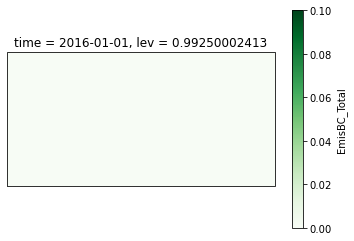

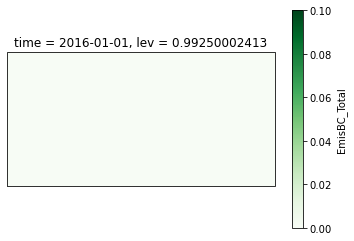

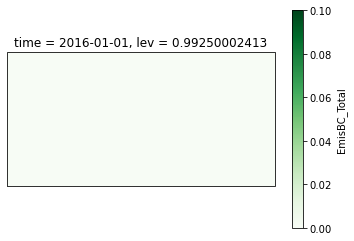

In [101]:
for p in ['BC_op','BC_perm','BC_const']:
    fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
    
    (ds_emispulse -ds_emisbase)['EmisBC_Total'].isel(lev = 0, time = 0).plot(vmax = 1e-1, transform = ccrs.PlateCarree(), cmap = 'Greens')
    #ax

In [53]:
f = xr.Dataset(
    data_vars = dict(f = (["emis_profile","time"], np.zeros([ len(['BC_op','BC_perm','BC_const']),len(time)]))),
    coords = dict(
        emis_profile = ['BC_op','BC_perm','BC_const'],
        time = time
    )

)

In [54]:
#lev mean of G 
for p in ['BC_op','BC_perm','BC_const']:
    f['f'].loc[dict(emis_profile = p)] = (utils.global_w_mean(regrid_out.loc[dict(emis_profile = p)], 'f'))


## Extend Timescale

In [55]:

G_ext = xr.Dataset(
    data_vars = dict(conc_dif = (["time","lev","lat","lon"], 
                          np.zeros([ len(time), 
                                    len(ds_base['lev']),
                                    len(ds_base['lat']),
                                    len(ds_base['lon'])]))),
    coords = dict(
        time = time,
        lev = ("lev", ds_base['lev']),
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
    ))

In [56]:
G_ext = xr.concat([G,G_ext['conc_dif']], dim = 'time').sortby('time')

In [61]:
G_ext = G_ext.assign_coords(time = np.arange(0.5,len(G_ext['time'])+ 0.5))
f0 = f0.values
f= f.assign_coords(time = np.arange(0,len(f['time']))) #inputting a x2 until we get our doubled emissions as daily data

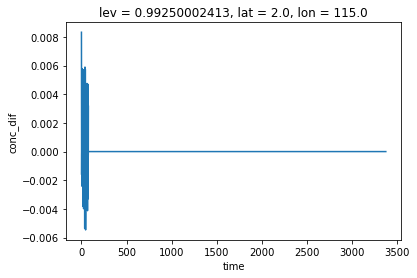

In [83]:
G_ext.sel(lon = 113, lat = 1, method = 'nearest').isel(lev = 0).plot()
plt.xlim()

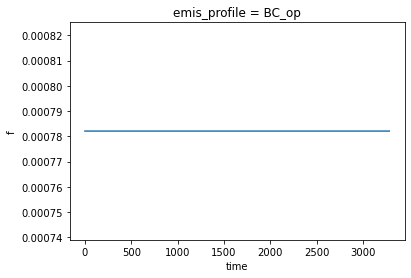

In [79]:
f.sel(emis_profile = 'BC_op')['f'].plot()

## Greens function convolution

In [145]:
Ndt = 100
dt = 1 #days
tp_range = np.arange(0, dt*Ndt, dt)
t_range = tp_range+0.5
Δt = 1.


In [146]:
C_ds = xr.Dataset(
    data_vars = dict(c = (["emis_profile","tp","lev","lat","lon","time"], np.zeros([ len(['BC_op','BC_perm','BC_const']), len(tp_range),len(ds_base['lev']),len(ds_base['lat']),len(ds_base['lon']),len(t_range)]))),
    coords = dict(
        emis_profile = ['BC_op','BC_perm','BC_const'],
        tp = tp_range,
        lev = ("lev", ds_base['lev']),
        lat = ("lat", ds_base['lat']),
        lon = ("lon", ds_base['lon']),
        time = t_range
    )

)

In [148]:
for p in ['BC_op','BC_perm','BC_const']:
    for i, tp in enumerate(tp_range):
        for t in t_range:
            C_ds['c'].loc[dict(emis_profile = p,tp = tp, time = t)] = utils.G_f_kernel(G_ext, f['f'].sel(emis_profile = p), t, tp,Δt, dt, f0)



In [149]:
C_df = C_ds.isel(lev = 0, emis_profile = 0).sel(lat = 35, lon = 105, method = 'nearest').drop(['lat','lon','lev']).to_dataframe().unstack()['c']

In [155]:
C_ds.to_netcdf('C_ds_100_indo.ncf')

## Import and plot

In [2]:
C_ds = xr.open_dataset('C_ds_100_indo.ncf')

In [3]:
C_ds = C_ds.sum(dim = 'tp')

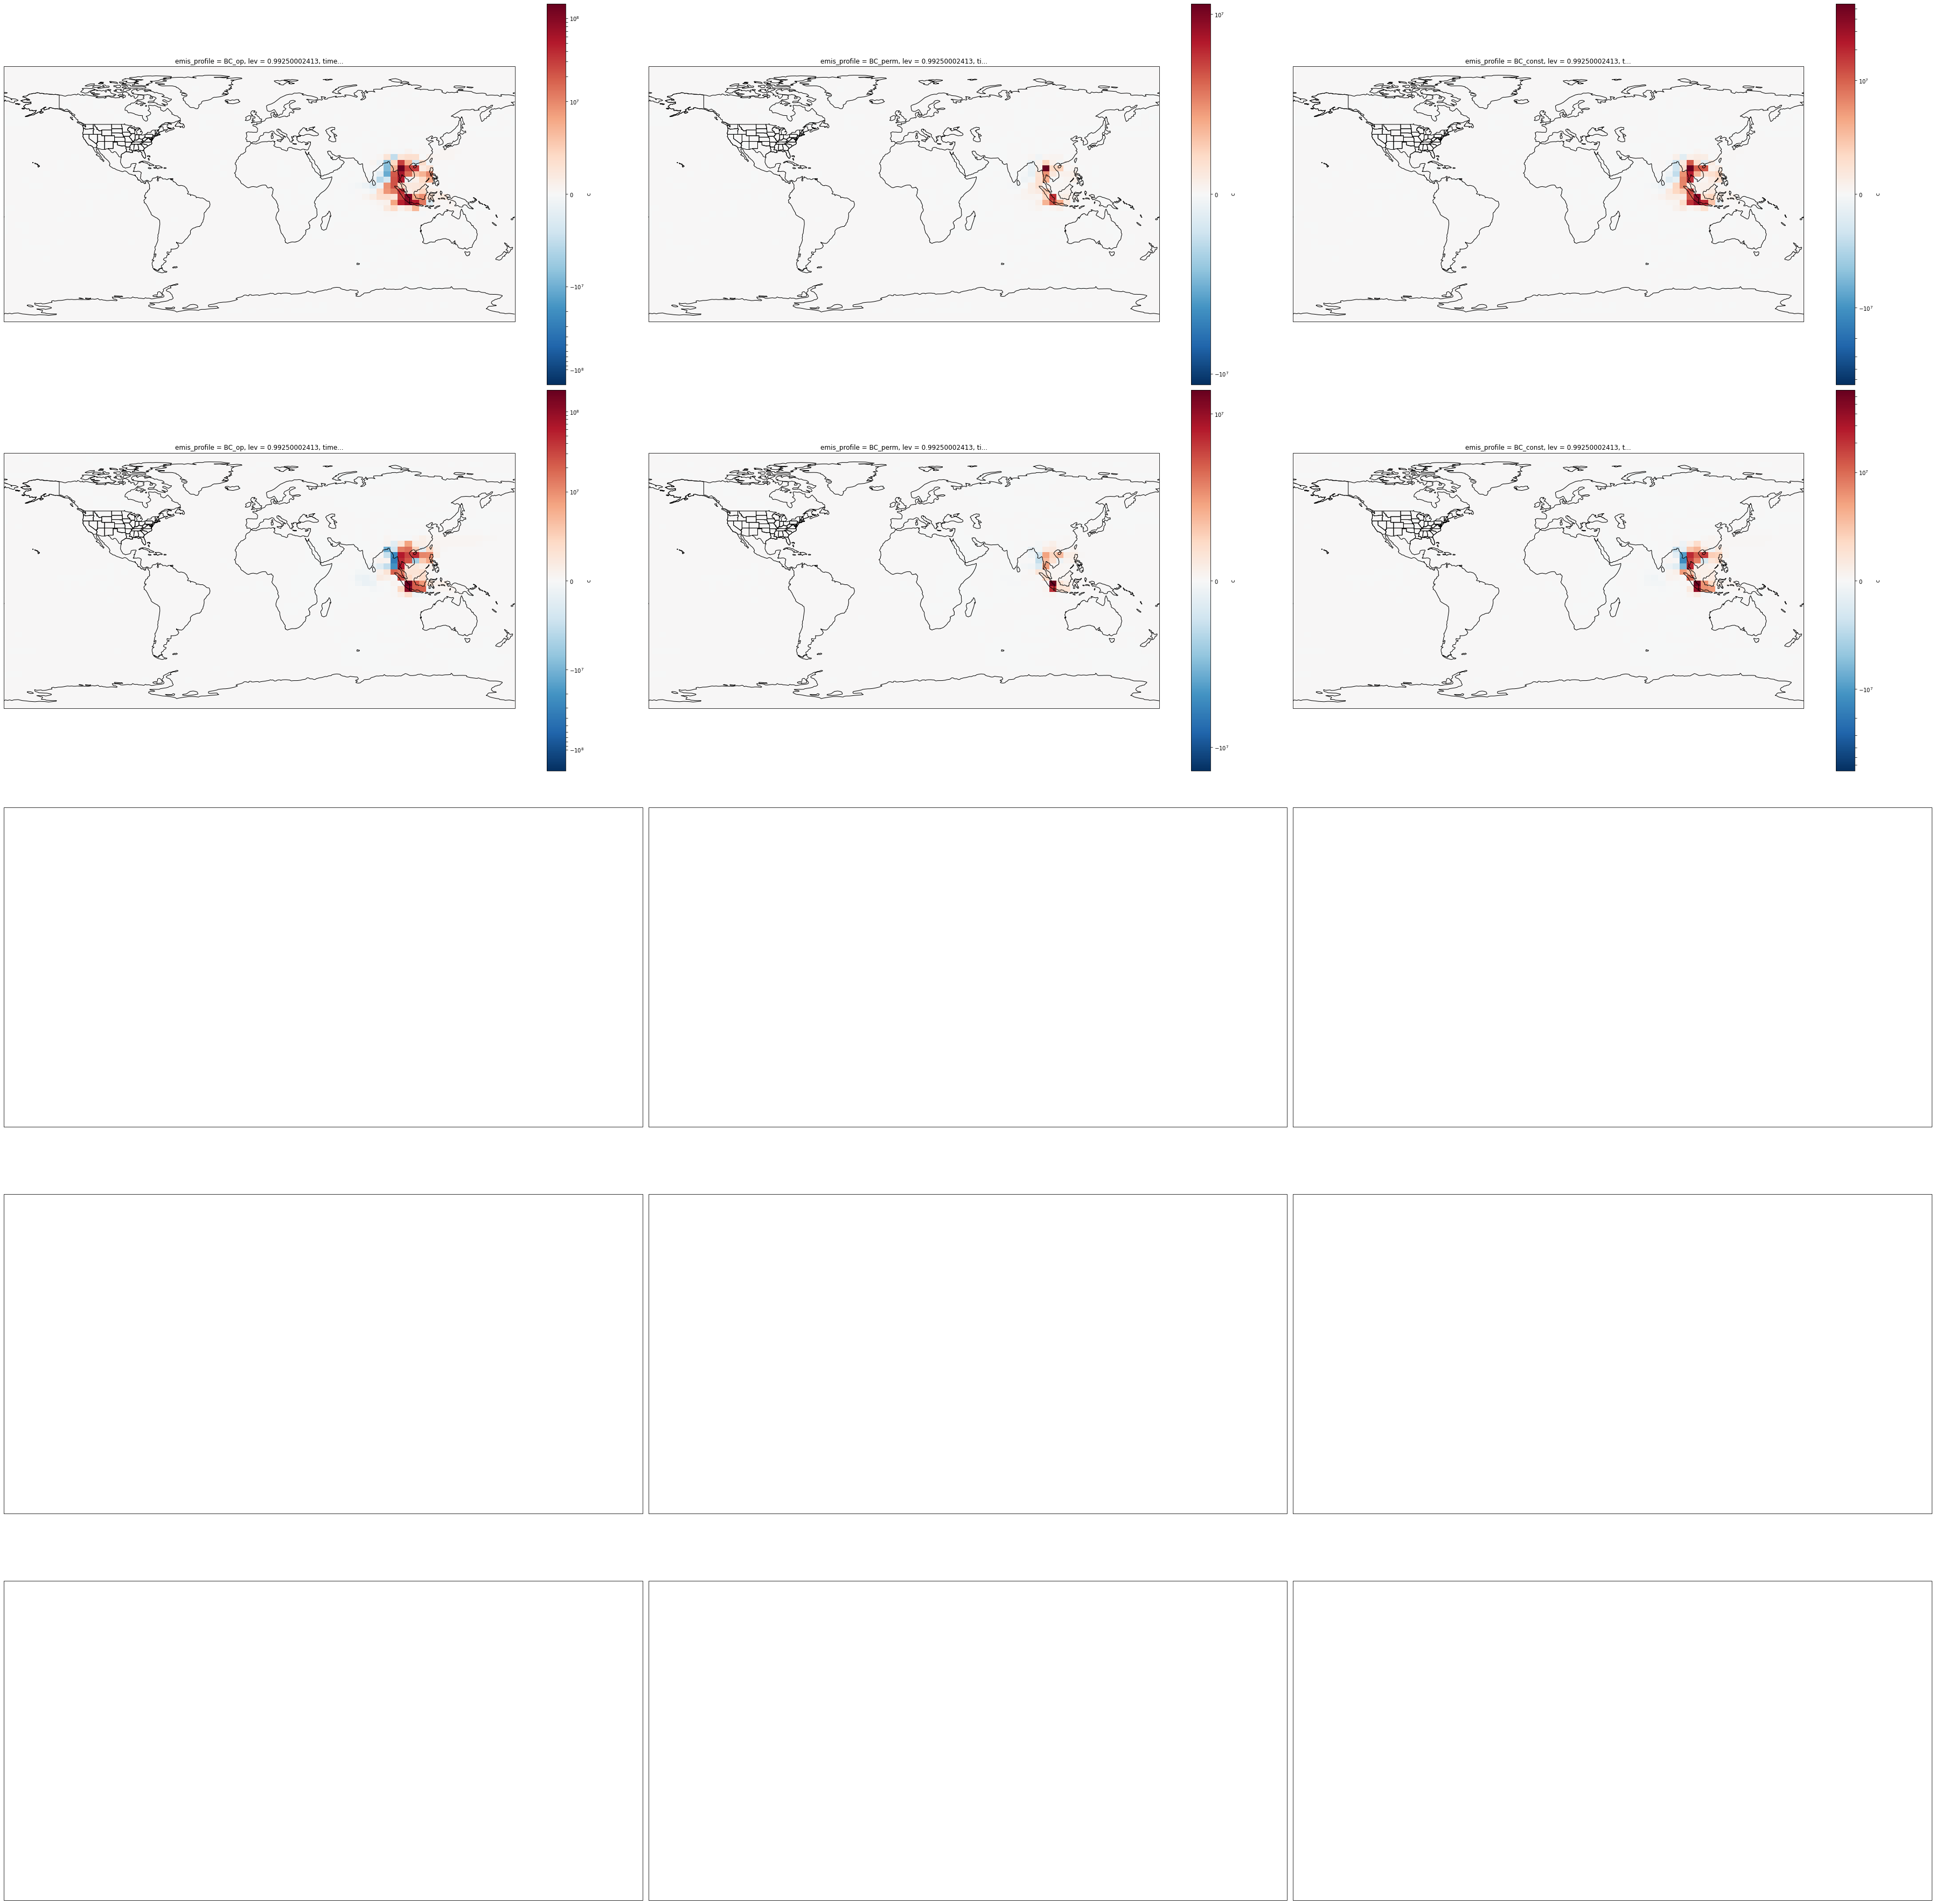

In [53]:
fig, axes = plt.subplots(5,3, figsize = [50,50], subplot_kw={'projection':ccrs.PlateCarree()})
for idx_t, t in enumerate([10,15]):
    for idx_p, p in enumerate(['BC_op','BC_perm','BC_const']):
        vmin = 0
        vmax = .1
        C_ds.sum(dim = 'tp').isel(lev = 0, time = t).sel(emis_profile = p)['c'].plot(ax = axes[idx_t,idx_p], transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e7))
        axes[idx_t,idx_p].coastlines()
        axes[idx_t,idx_p].add_feature(cfeat.STATES)
plt.tight_layout()

In [4]:
for idx_t, t in enumerate(np.arange(0,5)):
    vmin = -1e8
    vmax = 1e8
    fig, axes = plt.subplots(1,2, figsize = [10,3], subplot_kw={'projection':ccrs.PlateCarree()})

    (
        C_ds.sum(dim = 'tp').sel(emis_profile = 'BC_const')['c'] +
        C_ds.sum(dim = 'tp').sel(emis_profile = 'BC_perm')['c']).isel(lev = 0, time = t).plot(ax = axes[ 1], transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e4), 
                                                                                              vmin = vmin, vmax = vmax, extend = 'both', cmap = 'RdBu')

    (C_ds.sum(dim = 'tp').sel(emis_profile = 'BC_op')['c']).isel(lev = 0, time = t).plot(ax = axes[ 0], transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e4), 
                                                                                         vmin = vmin, vmax = vmax, extend = 'both', cmap = 'RdBu')
    axes[ 1].set_title(f'Permitted and Under Construction, Day {t}')
    axes[ 0].set_title(f'Operating, Day {t}')

    axes[ 1].coastlines()
    axes[ 1].add_feature(cfeat.STATES)

    axes[ 0].coastlines()
    axes[ 0].add_feature(cfeat.STATES)
    plt.tight_layout()
    
    plt.savefig(f'figures/indo_{t}_mv.png', dpi = 150, bbox_inches = 'tight')
    plt.close()

In [86]:
for idx_t, t in enumerate(np.arange(0.5,80.5)):
    vmin = 1e4
    vmax = 1e8
    fig, ax = plt.subplots(figsize = [5,3], subplot_kw={'projection':ccrs.PlateCarree()})
    if t <40.5:
        (C_ds.sel(emis_profile = 'BC_op')['c']).isel(lev = 0).sel(time = t).plot(ax = ax, transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e5), 
                                                                                              vmin = vmin, vmax = vmax, extend = 'max', cmap = 'pink_r')
    elif t >=40.5 and t <80.5:
        (C_ds.sel(emis_profile = 'BC_op')['c'] + 
         C_ds.sel(emis_profile = 'BC_const')['c'].sel(time = slice(40,100))).isel(lev = 0).sel(time = t).plot(ax = ax, transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e5), 
                                                                                                  vmin = vmin, vmax = vmax, extend = 'max', cmap = 'pink_r')

    elif t >= 60.5:
        (C_ds.sel(emis_profile = 'BC_op')['c'] + 
         C_ds.sel(emis_profile = 'BC_const')['c'].sel(time = slice(40,100)) + 
         C_ds.sel(emis_profile = 'BC_perm')['c'].sel(time = slice(60,100))).isel(lev = 0).sel(time = t).plot(ax = ax, transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e5), 
                                                                                                  vmin = vmin, vmax = vmax, extend = 'max', cmap = 'pink_r')

    ax.set_title(f'Day {t-.5}')

    ax.coastlines()
    ax.add_feature(cfeat.STATES)

    plt.tight_layout()
    plt.savefig('figures/' + f"{idx_t:04d}", dpi = 150, bbox_inches = 'tight')
    plt.close()

In [ ]:
for idx_t, t in enumerate(np.arange(0,5)):
    vmin = -1e8
    vmax = 1e8
    fig, axes = plt.subplots(1,2, figsize = [10,3], subplot_kw={'projection':ccrs.PlateCarree()})

    (
        C_ds.sum(dim = 'tp').sel(emis_profile = 'BC_const')['c'] +
        C_ds.sum(dim = 'tp').sel(emis_profile = 'BC_perm')['c']).isel(lev = 0, time = t).plot(ax = axes[ 1], transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e4), 
                                                                                              vmin = vmin, vmax = vmax, extend = 'both', cmap = 'RdBu')

    (C_ds.sum(dim = 'tp').sel(emis_profile = 'BC_op')['c']).isel(lev = 0, time = t).plot(ax = axes[ 0], transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e4), 
                                                                                         vmin = vmin, vmax = vmax, extend = 'both', cmap = 'RdBu')
    axes[ 1].set_title(f'Permitted and Under Construction, Day {t}')
    axes[ 0].set_title(f'Operating, Day {t}')

    axes[ 1].coastlines()
    axes[ 1].add_feature(cfeat.STATES)

    axes[ 0].coastlines()
    axes[ 0].add_feature(cfeat.STATES)
    plt.tight_layout()
    
    plt.savefig(f'figures/indo_{t}_mv.png', dpi = 150, bbox_inches = 'tight')
    plt.close()

In [5]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = tas[0,:,:].plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=-40, vmax=40,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(tas[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=40,       # Could also be iterable or list
    interval=200     # ms between frames
)

/bin/bash: convert: command not found


In [ ]:
fig, axes = plt.subplots(5,3, figsize = [50,50], subplot_kw={'projection':ccrs.PlateCarree()})
for idx_t, t in enumerate([10,15]):
    for idx_p, p in enumerate(['BC_op','BC_perm','BC_const']):
        vmin = 0
        vmax = .1
        C_ds.sum(dim = 'tp').isel(lev = 0, time = t).sel(emis_profile = p)['c'].plot(ax = axes[idx_t,idx_p], transform = ccrs.PlateCarree(),norm = SymLogNorm(linthresh = 1e7))
        axes[idx_t,idx_p].coastlines()
        axes[idx_t,idx_p].add_feature(cfeat.STATES)
plt.tight_layout()

# Old

## Create Emissions Profiles

df_coal_indo[['BC_daily','name','latitude','longitude']].set_index(['latitude','longitude'])[df_coal_indo[['BC_daily','name','latitude','longitude']].set_index(['latitude','longitude']).index.duplicated(keep = False)] 

df_coal_indo.loc[df_coal_indo['name'] == 'Dabu Coal','latitude'] = 24.4057171
df_coal_indo.loc[df_coal_indo['name'] == 'Dabu Coal','longitude'] = 116.5877945
df_coal_indo.loc[df_coal_indo['name'] == 'Yemazhai power station','latitude'] = 26.484308
df_coal_indo.loc[df_coal_indo['name'] == 'Yemazhai power station','longitude'] = 105.619091
df_coal_indo.loc[df_coal_indo['name'] == 'Bohe Coal','latitude'] = 21.441033
df_coal_indo.loc[df_coal_indo['name'] == 'Bohe Coal','longitude'] = 111.289628
df_coal_indo.loc[df_coal_indo['name'] == 'Yuelian Coal','latitude'] = 24.9762732
df_coal_indo.loc[df_coal_indo['name'] == 'Yuelian Coal','longitude'] = 112.5531543 

df_coal_indo['commissioning_year'].max()

df_coal_indo = df_coal_indo[['BC_daily','name','owner','latitude','longitude']].set_index(['latitude','longitude'])

sum_value = df_coal_indo[df_coal_indo.index.duplicated(keep = False)].sum()['BC_daily'] #Jiulong Paper Mill Jiulong power station Hailong

df_coal_indo = df_coal_indo[~df_coal_indo.index.duplicated(keep = 'first')]

df_coal_indo.loc[df_coal_indo['name'] == 'Jiulong Paper Mill Hailong power station','BC_daily'] = sum_value

ds_above =  xr.Dataset.from_dataframe(df_coal_indo.loc[df_coal_indo['BC_daily']> df_coal_indo['BC_daily'].mean()])

ds_above = ds_above.rename({'BC_daily' : 'BC_high'})

ds_below = xr.Dataset.from_dataframe(df_coal_indo.loc[df_coal_indo['BC_daily']< df_coal_indo['BC_daily'].mean()])

ds_below = ds_below.rename({'BC_daily' : 'BC_low'})

ds_indo = xr.Dataset.from_dataframe(df_coal_indo)

df_coal_indo.loc[~(df_coal_indo['BC_daily']== df_coal_indo['BC_daily'].max())]

ds_indo.where(ds_indo.BC_daily != ds_indo.BC_daily.max())

ds_indo = xr.merge([ds_indo, ds_below, ds_above])

ds_indo = ds_indo.fillna(0)